# Расчет показателей надежности восстанавливаемой системы с двумя состояниями

In [1]:
# Импорт библиотек и настройка среды
%matplotlib inline
%precision 3

from matplotlib.pyplot import plot, xlabel, ylabel, title, grid, axhline, legend, show, ylim, xlim, rcParams, ticklabel_format
from numpy import matrix, linspace, ravel, vstack, vectorize
from scipy.integrate import odeint, quad
from scipy import interpolate
from IPython.display import Image
%config InlineBackend.figure_formats = ['svg']  #установить векторный формат для графиков

## Постановка задачи

Требуется найти вероятности состояний для восстанавливаемого объекта с использованием графа состояний и уравнений Колмогорова. С использованием вероятностей состояний требуется рассчитать основные показатели надежности. В начальный момент времени система находится в исправном состоянии.

Известно, что интенсивность отказов $\lambda = 10^{-3} $, интенсивность восстановления $\mu = 2\lambda$. Потоки событий в системе - простейшие.

In [2]:
Lambda = 1e-3 #Интенсивность отказов
Mu = 2 * Lambda #Интенсивность восстановления

## Математическая модель

### Граф состояний

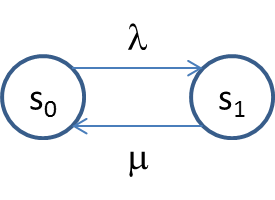

In [3]:
Image('pics/2states.png', embed=True)

### Система уравнений Колмогорова

\begin{equation}
    \left\{
        \begin{aligned}
            \frac{dp_0(t)}{dt} & = -\lambda p_0(t) + \mu p_1(t) \\
            \frac{dp_1(t)}{dt} & = \lambda p_0(t) - \mu p_1(t) \\
        \end{aligned}
    \right.
\end{equation}

Начальные условия: $$ p_0(0)=1, p_1(0)=0 $$

In [4]:
#Начальные условия:
p0 = [1, 0]

#Правые части уравнений (вектор производных):
def dp_dt(p, t):
    dp0 = -Lambda * p[0] + Mu * p[1]
    dp1 = Lambda * p[0] - Mu * p[1]
    return [dp0, dp1]

#Сетка для интегрирования
N = 200 #число шагов
tk = 4/Lambda #конечный момент времени
t = linspace(0, tk, N+1)

#Решение системы
p = odeint(dp_dt, p0, t)

Решение системы дифференциальных уравнений
См. также [справку](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) и [пример](http://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/integrate.html)

### Система уравнений Колмогорова для стационарного режима

\begin{equation}
    \left\{
        \begin{aligned}
            -\lambda P_0 + \mu P_1 & = 0 \\
            P_0 + P_1 = 1 \\
        \end{aligned}
    \right.
\end{equation}

Предельные вероятности состояний можно найти, решив систему линейных уравнений для стационарного режима

In [5]:
A = matrix([[-Lambda, Mu],
            [1,       1]])

B = matrix([[0], 
            [1]])

P = A.I * B

# В результате решения системы получается вектор-столбец - матрица с 2 строками и 1 столбцом
# здесь она преобразуется в одномерный массив для упрощения индексации
P = ravel(P) 

print('Предельные вероятности состояний: P0 = {0:.2f}, P1 = {1:.2f}'.format(P[0], P[1]))

Предельные вероятности состояний: P0 = 0.67, P1 = 0.33


### Вероятности состояний

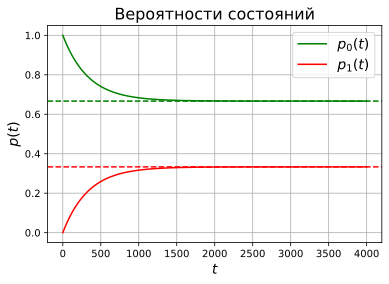

In [6]:
#График
plot(t,p[:,0],'g-',label = r'$p_0(t)$') #вероятности состояний
plot(t,p[:,1],'r-',label = r'$p_1(t)$')

axhline(y=P[0], linestyle='--', color='green') #предельные вероятности
axhline(y=P[1], linestyle='--', color='red')

legend(loc='best', fontsize=14) #легенда
grid() #сетка

xlabel('$t$', size=14) #подписи для осей и графика
ylabel('$p(t)$', size=14)
title('Вероятности состояний', size=16);

### Функции, интерполирующие вероятности состояний

Решение системы уравнений численным методом дает таблицу значений вероятностей состояний в дискретных точках

In [7]:
table = vstack((t, p[:, 0], p[:, 1])).T
print('Решение системы уравнений на сетке:')
print(table[1:7, :])
print('...')

Решение системы уравнений на сетке:
[[2.000e+01 9.806e-01 1.941e-02]
 [4.000e+01 9.623e-01 3.769e-02]
 [6.000e+01 9.451e-01 5.491e-02]
 [8.000e+01 9.289e-01 7.112e-02]
 [1.000e+02 9.136e-01 8.639e-02]
 [1.200e+02 8.992e-01 1.008e-01]]
...


Для удобства работы можно преобразовать эти дискретные данные в непрерывные функции, определенные на интервале $\left[ 0, t_k \right]$

[Примеры интерполяции данных](http://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)

In [8]:
# Используется сплайновая интерполяция
p0 = interpolate.InterpolatedUnivariateSpline(t,p[:, 0]) #функция определена на интервале [0, tk]
p1 = interpolate.InterpolatedUnivariateSpline(t,p[:, 1])

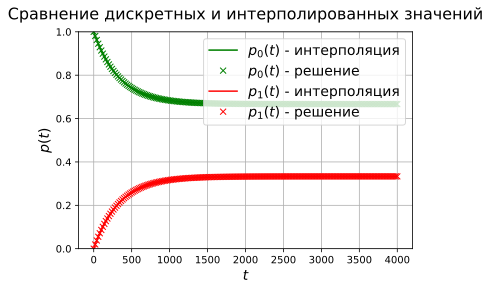

In [9]:
# Сравнение дискретных и интерполированных значений вероятностей
tnew = linspace(0.001, tk, 2*N+1)
plot(tnew,p0(tnew),'g-', label=r'$p_0(t)$ - интерполяция') #интерполированные значения
plot(t,p[:, 0], 'gx', label=r'$p_0(t)$ - решение') #дискретные значения на сетке
plot(tnew,p1(tnew),'r-', label=r'$p_1(t)$ - интерполяция')
plot(t,p[:, 1], 'rx', label=r'$p_1(t)$ - решение')
legend(loc='upper right', fontsize=14) #легенда
grid()
ylim([0,1])
#xlim([0,500])

xlabel('$t$', size=14) #подписи для осей и графика
ylabel('$p(t)$', size=14)
title(u'Сравнение дискретных и интерполированных значений', size=16, y=1.03);

## Расчет показателей надежности

### Коэффициент готовности

Стационарный коэффициент готовности:

$$К_Г = \sum_{s \in U} P_s, $$

где $U$ - множество работоспособных состояний


Функция готовности:

$$К_Г(t) = \sum_{s \in U} p_s(t), $$ где $U$ - множество работоспособных состояний

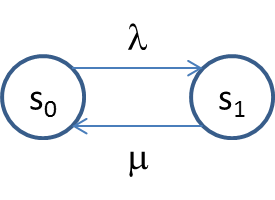

In [10]:
Image('pics/2states.png', embed=True)

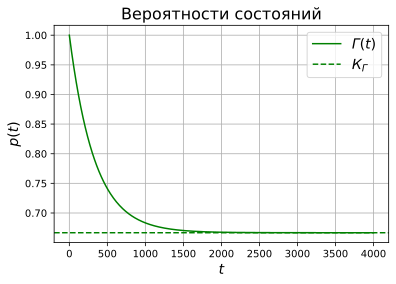

In [11]:
# Стационарный коэффициент готовности:
K_G = P[0]

# Функция готовности:
def G(t):
    return p0(t) #в данном случае совпадает с вероятностью состояния s0


#График
plot(tnew,G(tnew),'g-',label = r'$Г(t)$') #Функция готовности
axhline(y=K_G, linestyle='--', color='green', label=r'$К_Г$') #Стационарный коэффициент готовности

legend(loc='best', fontsize=14) #легенда
grid() #сетка

xlabel('$t$', size=14) #подписи для осей и графика
ylabel('$p(t)$', size=14)
title('Вероятности состояний', size=16);

### Параметр потока отказов

Стационарный параметр потока отказов:  $ \omega_f = \lambda P_0 $

Параметр потока отказов: $ \omega(t) = \lambda p_0(t)$

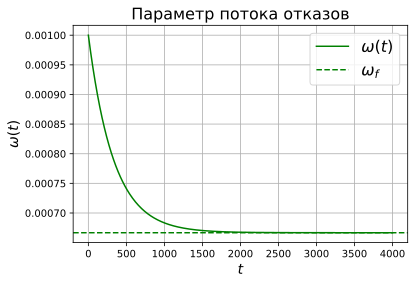

In [12]:
# Стационарный параметр потока отказов:
omega_f = Lambda * P[0]

# Параметр потока отказов:
def omega(t):
    return Lambda * p0(t)

#График
plot(tnew,omega(tnew),'g-',label = r'$\omega(t)$') # Параметр потока отказов
axhline(y=omega_f, linestyle='--', color='green', label=r'$\omega_f$') #Стационарный параметр потока отказов

legend(loc='best', fontsize=16) #легенда
grid() #сетка

xlabel('$t$', size=14) #подписи для осей и графика
ylabel('$\omega(t)$', size=14)
title('Параметр потока отказов', size=16);

### Ведущая функция потока отказов

$$\Omega(t)=\int_{0}^t\omega(\tau)d\tau$$

In [13]:
# Ведущая функция потока отказов
def Omega(t):
    return quad(omega,0,t)[0]

### Средняя наработка на отказ

Предельное значение (в стационарном режиме):
    
$$ \bar{t_f} = \frac{К_Г}{w_f} $$

Средняя наработка на отказ:

$$ \bar{t}(t) = \frac{\int_0^t Г(\tau)d\tau}{\Omega(t)} $$

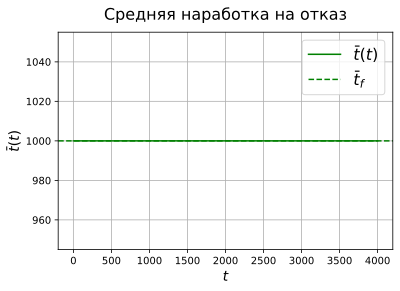

In [14]:
# Предельное значение средней наработки на отказ
t_avg_f = K_G / omega_f

# Средняя наработка на отказ
#@vectorize

def intG(t):
    return quad(G, 0, t)[0]

@vectorize
def t_avg(t):
    return  intG(t) / Omega(t)

#График
plot(tnew,t_avg(tnew),'g-',label = r'$\bar{t}(t)$') # Средняя наработка на отказ
#plot(tnew,Omega(tnew),'g-',label = r'$\bar{t}(t)$') # Средняя наработка на отказ
axhline(y=t_avg_f, linestyle='--', color='green', label=r'$\bar{t}_f$') #Стационарное значение средней наработки на отказ

#ticklabel_format(style='plain', axis='y')
legend(loc='best', fontsize=16) #легенда
grid() #сетка

xlabel('$t$', size=14) #подписи для осей и графика
ylabel(r'$\bar{t}(t)$', size=14)
title('Средняя наработка на отказ', size=16, y=1.03);